<a href="https://colab.research.google.com/github/swagata87/school2024iop/blob/main/cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,GlobalAvgPool2D )
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Data Management

## Download Data

In [3]:
##### hint: Write code to download data

#!pip install -q kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#!chmod 600 /root/.kaggle/kaggle.json
#!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
#!unzip "/content/face-mask-12k-images-dataset.zip" -d "/content/dataset/"

## Prepare data

In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4

In [ ]:
ds_masked=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/Face Mask Dataset/Train/WithMask", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 5000 files belonging to 1 classes.


In [ ]:
len(ds_masked)

40

In [ ]:
ds_test_masked=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/Face Mask Dataset/Test/WithMask", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 483 files belonging to 1 classes.


In [ ]:
len(ds_test_masked)

4

In [ ]:
ds_unmasked=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/Face Mask Dataset/Train/WithoutMask", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 5000 files belonging to 1 classes.


In [ ]:
len(ds_unmasked)

40

In [ ]:
def preprocess(image):
  return tf.cast(image,tf.float32)/127.5 - 1.0

In [ ]:
train_masked_dataset = (
    ds_masked
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_masked_dataset = (
    ds_test_masked
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_unmasked_dataset = (
    ds_unmasked
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset=tf.data.Dataset.zip((train_masked_dataset, train_unmasked_dataset))

In [ ]:
train_dataset

<_ZipDataset element_spec=(TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None))>

In [ ]:
for d in train_dataset.take(1):
  d_masked,d_unmasked=d
  print(d_masked.shape,d_unmasked.shape)

(128, 64, 64, 3) (128, 64, 64, 3)


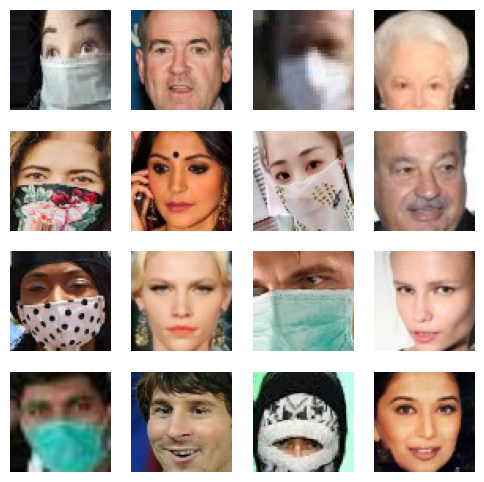

In [ ]:
plt.figure(figsize = (6,6))
k=0
n = 16
for i in range(n):
  ax = plt.subplot(4,4, k+1)
  if i%2==0:
    plt.imshow((d_masked[i]+1)/2)
  if i%2!=0:
    plt.imshow((d_unmasked[i]+1)/2)

  plt.axis("off")
  k+=1

# Modeling

In [ ]:
def downsample(filters,kernel_size,apply_instance_norm=True,n_strides=2):

  model=tf.keras.Sequential()
  ### hint: conv2D
  if apply_instance_norm:
    ### hint: instance normalization
  model.add(LeakyReLU(0.2))

  return model

In [ ]:
def upsample(filters,kernel_size):

  model=tf.keras.Sequential([
      Conv2DTranspose(filters,kernel_size,strides=2,padding='same',
             kernel_initializer=tf.keras.initializers.RandomNormal(0.,0.02),use_bias=False),
      tfa.layers.InstanceNormalization(),
      ### hint: leaky relu with 0.2

  ])
  return model

In [ ]:
def generator():
  input=Input((IM_SHAPE[0],IM_SHAPE[1],3))
  x=input
  store=[]
  for filter in [32,64,128,256,512,]:
    x=downsample(filter,4)(x)
    store.append(x)

  for filter in [512,256,128,64,32]:
    x=tf.concat([x,store.pop()],axis=-1)
    x=upsample(filter,4)(x)

  ### hint: x=Conv2DTranspose (....)

  model=tf.keras.Model(input,x, name='unet_generator')
  return model

In [ ]:
generator().summary()

Model: "unet_generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 32)           1600      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 16, 16, 64)           32896     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 8, 8, 128)            131328    ['sequential_1[0][0]']        
                                                                                     

In [ ]:
def discriminator():
  ### write on your own
  return model

In [ ]:
discriminator().summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_10 (Sequential)  (None, 32, 32, 32)        1536      
                                                                 
 sequential_11 (Sequential)  (None, 16, 16, 64)        32896     
                                                                 
 sequential_12 (Sequential)  (None, 8, 8, 128)         131328    
                                                                 
 sequential_13 (Sequential)  (None, 4, 4, 256)         524800    
                                                                 
 sequential_14 (Sequential)  (None, 4, 4, 256)         1049088   
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 1)         

In [ ]:
generator_masked_unmasked=generator()
generator_unmasked_masked=generator()

discriminator_unmasked=discriminator()
discriminator_masked=discriminator()

In [ ]:
class CycleGAN(tf.keras.Model):
  def __init__(
      self,
      discriminator_unmasked,discriminator_masked,
      generator_masked_unmasked,generator_unmasked_masked):
    super(CycleGAN,self).__init__()

    self.discriminator_unmasked=discriminator_unmasked
    self.discriminator_masked=discriminator_masked
    self.generator_masked_unmasked=generator_masked_unmasked
    self.generator_unmasked_masked=generator_unmasked_masked

  def compile(
      self,
      discriminator_optimizer,generator_optimizer,
      discriminator_loss_fn,generator_loss_fn,
      cycle_loss_fn,
      lambda_cycle,):
    super(CycleGAN,self).compile()

    self.discriminator_optimizer=discriminator_optimizer
    self.generator_optimizer=generator_optimizer
    self.discriminator_loss_fn=discriminator_loss_fn
    self.generator_loss_fn=generator_loss_fn
    self.cycle_loss_fn=cycle_loss_fn
    self.lambda_cycle=lambda_cycle
    self.d_loss_masked_metric=tf.keras.metrics.Mean(name='d_loss_masked')
    self.d_loss_unmasked_metric=tf.keras.metrics.Mean(name='d_loss_unmasked')
    self.g_loss_masked_unmasked_metric=tf.keras.metrics.Mean(name='g_loss_masked_unmasked')
    self.g_loss_unmasked_masked_metric=tf.keras.metrics.Mean(name='g_loss_unmasked_masked')


  @property
  def metrics(self):
    return [self.d_loss_masked_metric,self.d_loss_unmasked_metric,
            self.g_loss_masked_unmasked_metric,self.g_loss_unmasked_masked_metric]

  def train_step(self,real_images):
    real_masked,real_unmasked=real_images

    ######## Discriminator
    fake_unmasked=self.generator_masked_unmasked(real_masked)
    fake_masked=self.generator_unmasked_masked(real_unmasked)

    with tf.GradientTape(persistent=True) as recorder:
      real_unmasked_predictions=self.discriminator_unmasked(real_unmasked)
      fake_unmasked_predictions=self.discriminator_unmasked(fake_unmasked)
      d_loss_unmasked=self.discriminator_loss_fn(real_unmasked_predictions,fake_unmasked_predictions)

      real_masked_predictions=self.discriminator_masked(real_masked)
      fake_masked_predictions=self.discriminator_masked(fake_masked)
      d_loss_masked=self.discriminator_loss_fn(real_masked_predictions,fake_masked_predictions)

    partial_derivatives = recorder.gradient(d_loss_unmasked,self.discriminator_unmasked.trainable_weights)
    self.discriminator_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator_unmasked.trainable_weights))
    partial_derivatives = recorder.gradient(d_loss_masked,self.discriminator_masked.trainable_weights)
    self.discriminator_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator_masked.trainable_weights))

    ############# Generator
    with tf.GradientTape(persistent=True) as recorder:

      fake_unmasked=self.generator_masked_unmasked(real_masked)
      fake_masked_cycled=self.generator_unmasked_masked(fake_unmasked)

      fake_masked=self.generator_unmasked_masked(real_unmasked)
      fake_unmasked_cycled=self.generator_masked_unmasked(fake_masked)

      fake_unmasked_predictions=self.discriminator_unmasked(fake_unmasked)
      g_loss_unmasked=self.generator_loss_fn(fake_unmasked_predictions)

      fake_masked_predictions=self.discriminator_masked(fake_masked)
      g_loss_masked=self.generator_loss_fn(fake_masked_predictions)

      cycle_consistency_loss=self.cycle_loss_fn(fake_masked_cycled,real_masked)+self.cycle_loss_fn(fake_unmasked_cycled,real_unmasked)
      cycle_consistency_loss*=self.lambda_cycle

      g_loss_masked+=cycle_consistency_loss
      g_loss_unmasked+=cycle_consistency_loss

    partial_derivatives = recorder.gradient(g_loss_masked,self.generator_unmasked_masked.trainable_weights)
    self.generator_optimizer.apply_gradients(zip(partial_derivatives, self.generator_unmasked_masked.trainable_weights))

    partial_derivatives = recorder.gradient(g_loss_unmasked,self.generator_masked_unmasked.trainable_weights)
    self.generator_optimizer.apply_gradients(zip(partial_derivatives, self.generator_masked_unmasked.trainable_weights))

    self.d_loss_masked_metric.update_state(d_loss_masked)
    self.d_loss_unmasked_metric.update_state(d_loss_unmasked)
    self.g_loss_unmasked_masked_metric.update_state(g_loss_masked)
    self.g_loss_masked_unmasked_metric.update_state(g_loss_unmasked)

    return {
        'g_loss_masked_unmasked':self.g_loss_unmasked_masked_metric.result(),
        'g_loss_unmasked_masked':self.g_loss_masked_unmasked_metric.result(),
        'd_loss_masked':self.d_loss_masked_metric.result(),
        'd_loss_unmasked':self.d_loss_unmasked_metric.result(),
        }

In [ ]:
def discriminator_loss_fn(real_predictions,fake_predictions):
  ### hint: write on your own

In [ ]:
def generator_loss_fn(fake_predictions):
  bce=tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
  return bce(tf.ones_like(fake_predictions),fake_predictions)

In [ ]:
def cycle_loss_fn(fake_cycled_image,real_image):
  return tf.reduce_mean(tf.abs(fake_cycled_image-real_image))

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
cycle_gan=CycleGAN(
    discriminator_unmasked,discriminator_masked,
    generator_masked_unmasked,generator_unmasked_masked)

In [ ]:
cycle_gan.compile(
    ### hint: write on your own
)

In [ ]:
!mkdir generated

In [ ]:
for d in test_masked_dataset.take(1):
  test_masked=d

In [ ]:
class Unmask(tf.keras.callbacks.Callback):
    ### hint: write on your own

In [4]:
cycle_gan.fit(
    ### hint: write on your own
)

NameError: name 'cycle_gan' is not defined